# FACE DETECTION

### Import All Libraries

In [1]:
# Got help from multiple web sources, notably:
#https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
#https://github.com/krsatyam1996/Face-recognition-and-identification
#https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.14-Image-Features.ipynb
#http://krasserm.github.io/2018/02/07/deep-face-recognition/


#import all libraries needed
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from skimage import data, color, feature, transform
import skimage.data
from sklearn.datasets import fetch_lfw_people
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import cv2
from sklearn.svm import SVC
from skimage.transform import resize
import pandas as pd


### Creating multiple negative images from dataset

In [2]:
#obtain negative images of different scaled sizes
def patches_neg(images, patch_no, scale, image_pos):
    
    size=image_pos[0].shape
    patches_neg_size = tuple((scale * np.array(size)).astype(int))
    patches = PatchExtractor(patch_size=size, max_patches=patch_no, random_state=0)
    negative_patches=patches.transform(images[np.newaxis])
    
    #correct patch size for scale changes 
    if scale != 1:
        negative_patches = np.array([transform.resize(patch, size)for patch in negative_patches])
    
    return negative_patches

### Import data to train on

In [3]:
#import images of peoples faces to use for positive images
people_faces = fetch_lfw_people()
image_pos = people_faces.images   #image_pos.shape= nx62x47

#import non human faces to use as negative images
non_human_faces_types = [ 'text', 'coins', 'moon', 'chelsea','clock', 'horse', 'camera', 'logo', 'hubble_deep_field', 
                          'immunohistochemistry']
non_human_faces = [color.rgb2gray(getattr(data, name)())for name in non_human_faces_types]

#creating multiple negative images
image_neg = np.vstack([patches_neg(image, 1000, scale, image_pos)for image in non_human_faces for scale in [0.5, 1.0, 2]])
#image_neg.shape = px62x47 similar to image_pos.shape= nx62x47


### Training/Testing set split

In [4]:
#obtain hog features from positive and negative images for training data
x_train = np.array([feature.hog(image) for image in chain(image_pos, image_neg)])
Y_train = np.zeros(x_train.shape[0])
Y_train[:image_pos.shape[0]] = 1

X_train, X_test, y_train, y_test = train_test_split(x_train, Y_train, random_state=42)


### Training SVC

In [5]:
#finding best hyperparameters for C to optimise results
grid = GridSearchCV(SVC(),{'C': [1.0, 2.0, 4.0, 8.0], 'kernel': ['linear'], 'gamma': [0.001, 0.0001]})
grid.fit(X_train, y_train)

#l=grid.cv_results_
#print(pd.DataFrame(l))

#retrain model with optimised parameters
model = grid.best_estimator_
model.fit(X_train, y_train)

#y_fit = model.predict(X_test)
#print(classification_report(y_test, y_fit))

#Train model with full training set (training+testing)
model.fit(x_train, Y_train)

#l2=grid.cv_results_
#print(pd.DataFrame(l2))


SVC(C=4.0, gamma=0.001, kernel='linear')

### Test image for detection

In [14]:
#import detection image
test_image = cv2.imread(r"C:\Users\user\Desktop\pictures\pictures\IMG_2067.jpg")  
test_image = test_image[80:240, 160:280]
test_image = skimage.color.rgb2gray(test_image)

#plt.imshow(test_image, cmap='gray')
#plt.axis('off');

### Detecting face in the image

In [15]:
#using a sliding window to scan over image to detect face
def sliding_window(images, scale, pos, x_dir=2, y_dir=2):
    
    size=pos[0].shape
    height, width = (int(co*scale) for co in size)
   
    for x in range(0, images.shape[0]-height, x_dir):
        for y in range(0, images.shape[1]-height, y_dir):
            patches = images[x:x+height, y:y+width]
            #boxes.append([i,i + height, j,j + width])
            if scale != 1:
                patches = transform.resize(patches, size)
            yield (x, y), patches, (height, width)       
            
scales=[1.0]  #can add mulitple slides to account for different sized face [0.2 0.5 1.0 1.5 2.0 3.0]
indices=[]
patches=[]
dims=[]

for i in scales:
    index, patch11, dim = zip(*sliding_window(test_image, scale=i, pos=image_pos))
    patches.extend(patch11)
    indices.extend(index)
    dims.extend(dim)

hog_patch = np.array([feature.hog(patch22) for patch22 in patches])
possible_det = model.predict(hog_patch)


### Non-max suppression 
to eliminate multiple bounding boxes

In [16]:
#non max suppression to narrow multiple detections, for same face, to one

def nms(face_bound_boxes, overlapping):
    
    remaining_box = []
    face_bound_boxes = face_bound_boxes.astype("float")

    x1 = face_bound_boxes[:,0]
    y1 = face_bound_boxes[:,1]
    x2 = face_bound_boxes[:,2]
    y2 = face_bound_boxes[:,3]

    box_areas = (x2-x1+1)*(y1-y2+1)
    y2_index = np.argsort(y2)
    
    #loop through index list computing box overlap ratios and removing boxes from list that dont 
    #meet the overlapping threshold
    while len(y2_index) > 0:
        end_index = len(y2_index)-1
        remaining_box.append(y2_index[end_index])
        
        box_start_large_x1 = np.maximum(x1[i], x1[y2_index[:end_index]])
        box_start_large_y1 = np.maximum(y1[i], y1[y2_index[:end_index]])
        box_end_large_x2 = np.minimum(x2[i], x2[y2_index[:end_index]])
        box_end_large_y2 = np.minimum(y2[i], y2[y2_index[:end_index]])
        
        height = np.maximum(0, box_end_large_y2 - box_start_large_y1 +1)
        width = np.maximum(0, box_end_large_x2 - box_start_large_x1 +1)
        
        overlap_ratio =(width*height)/box_areas[y2_index[:end_index]]
        y2_index = np.delete(y2_index, np.concatenate(([end_index], np.where(overlap_ratio+0.1 > overlapping)[0])))
        int_box = face_bound_boxes[remaining_box].astype("int")
    return int_box

### Isolate single bounding box

(-0.5, 119.5, 159.5, -0.5)

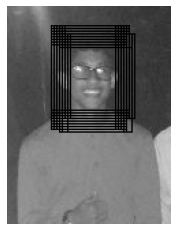

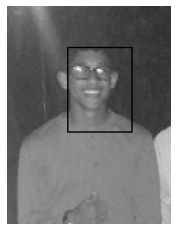

In [17]:
# get bounding boxes of detected face

indices = np.array(indices)
dims = np.array(dims)
indices=indices[possible_det == 1]
dims=dims[possible_det == 1]
boxes=[]

orig=test_image.copy()

for count, element in enumerate(indices):
    height, width = dims[count]
    i, j = element
    cv2.rectangle(orig,(j, i+height), (j+width, i), (0, 0, 255), 1)
    boxes.append((j,i+height,j+width,i))
boxes=np.array(boxes)

# multiple boxes will be present, for a single detection, therefore apply non maximum suppression
remaining_box = nms(boxes, 0.05)

# draw final detected box of faces and crop it out
crop_img  = []
for i, j, Ni, Nj in remaining_box:
    cv2.rectangle(test_image,(i, j), (Ni, Nj), (0, 255, 0), 1)
    crop_img  = test_image[Nj:j,i:Ni]

fig, ax = plt.subplots()
ax.imshow(orig, cmap='gray')
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')


### Crop face

(-0.5, 95.5, 95.5, -0.5)

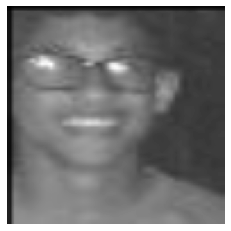

In [18]:
#crop detected face and resize to 96x96

image_resized = resize(crop_img, (96,96), anti_aliasing=False)  

fig, ax = plt.subplots()
ax.imshow(image_resized, cmap='gray')
ax.axis('off')